In [ ]:
!pip install sk-video

     |████████████████████████████████| 2.3 MB 14.3 MB/s 


In [ ]:
%matplotlib inline

from google.colab import files, drive    # upload
import numpy as np                       # mathematical calculations
from io import BytesIO                   # reading files
from PIL import Image             # image processing library
import matplotlib.pyplot as plt   # plotting library
import glob                        # find all files in a directory
from skvideo import io
from moviepy.editor import *
from joblib import Parallel, delayed
import cv2

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2654208/45929032 bytes (5.8%)5472256/45929032 bytes (11.9%)8511488/45929032 bytes (18.5%)11304960/45929032 bytes (24.6%)14262272/45929032 bytes (31.1%)17145856/45929032 bytes (37.3%)19972096/45929032 bytes (43.5%)22609920/45929032 bytes (49.2%)25272320/45929032 bytes (55.0%)27811840/45929032 bytes (60.6%)30490624/45929032 bytes (66.4%)33546240/45929032 bytes (73.0%)

In [ ]:
drive.mount('drive')

Mounted at drive


In [ ]:
path = "/content/drive/MyDrive/coding/Curve Fitting/esther-eye.avi"
clip = VideoFileClip(path)
clip.ipython_display(width = 400)

100%|█████████▉| 500/501 [00:02<00:00, 239.21it/s]


In [ ]:
videodata = io.vread(path)
print(videodata.shape, type(videodata))

(499, 350, 650, 3) <class 'numpy.ndarray'>


In [ ]:
def greyscale(image):
  image = (0.3 * image[:, :, 0]) + (0.59 * image[:, :, 1]) + (0.11 * image[:, :, 2])
  return image.astype(np.float32)
def smoother(image):
  output = image.copy().astype(np.float32)
  x, y = image.shape
  for a in range(1, x - 1):
    for b in range(1, y - 1):
      av = (image[a - 1, b- 1]) + (image[a - 1, b]) + (image[a - 1, b + 1])
      av += (image[a, b - 1 ]) + (image[a, b]) + (image[a, b + 1])
      av += (image[a + 1, b - 1]) + (image[a + 1, b]) + (image[a + 1, b + 1])
      av /= 9
      output[a, b] = av
  return output
def edge_detection(image):
  output = image.copy()
  x, y = image.shape
  for a in range(1, x - 1):
    for b in range(1, y - 1):
      output[a, b] = (4 * image[a, b]) - image[a - 1, b] - image[a + 1, b] - image[a, b - 1] - image[a, b + 1]
  return np.abs(output)
def binary(image):
  output = image.copy()
  output[output < 40] = 0
  output[output >= 40] = 255
  return output

class circle_model(object):
  def __init__(self, x, y, radius):
    self.x = x
    self.y = y
    self.r = radius
  
  def __str__(self):
    display = "cirle_model: x = {}, y = {}, r = {}".format(self.x, self.y, self.r)
    return display

  def circle(self):
    x = np.linspace(self.x - self.r, self.x + self.r, num = 100, endpoint = True)
    y1 = self.y + np.sqrt(np.square(self.r) - np.square(x - self.x))
    y2 = self.y - np.sqrt(np.square(self.r) - np.square(x - self.x))
    y = np.concatenate((y1, np.flip(y2)))
    x = np.concatenate((x, np.flip(x)))
    return np.squeeze(x), np.squeeze(y)
  
  def error(self, x, y):
    y1 = self.y + np.sqrt(np.square(self.r) - np.square(x - self.x))
    y2 = self.y - np.sqrt(np.square(self.r) - np.square(x - self.x))
    return min(np.abs(y1 - y), np.abs(y2 - y))

  @staticmethod
  def estimate(p1, p2, p3):
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]
    x3 = p3[0]
    y3 = p3[1]
    a = x1 * (y2 - y3) - y1 * (x2 - x3) + (x2 * y3) - (x3 * y2)
    b = (np.square(x1) + np.square(y1)) * (y3 - y2) + (np.square(x2) + np.square(y2)) * (y1 - y3) + (np.square(x3) + np.square(y3)) * (y2 - y1)
    c = (np.square(x1) + np.square(y1)) * (x2 - x3) + (np.square(x2) + np.square(y2)) * (x3 - x1) + (np.square(x3) + np.square(y3)) * (x1 - x2)
    d = (np.square(x1) + np.square(y1)) * ((x3 * y2) - (x2 * y3)) + (np.square(x2) + np.square(y2)) * ((x1 * y3) - (x3 * y1)) + (np.square(x3) + np.square(y3)) * ((x2 * y1) - (x1 * y2))
    est_r = np.sqrt((np.square(b) + np.square(c) - 4 * a * d)/(4 * np.square(a)))
    est_x = -1 * (b/(2 * a))
    est_y = -1 * (c/(2 * a))
    return circle_model(est_x, est_y, est_r)

In [ ]:
def find_coords(patch):
  x, y = patch.shape
  xarray = []
  yarray = []
  for i in range(x):
    for j in range(y):
      if patch[i, j] > 0:
        xarray.append(j)
        yarray.append(i)
  return np.array(xarray), np.array(yarray)
def linear_least_squares(x, y):
  X = np.array([np.array([i, 1]) for i in x])
  A = (X.transpose()).dot(X)
  A = np.linalg.inv(A)
  B = (X.transpose()).dot(y)
  model = A.dot(B)
  return model[0], model[1]
def ransac(x, y, patch):
  fig = plt.figure(figsize = [12, 4])
  plt.imshow(patch, cmap = "gray")
  inlier_percentage = 0.56
  min_inlier = inlier_percentage * x.size
  error_max = 25
  inlier_model = False
  best_error = 10000000000
  best_model = circle_model(0, 0, 0)
  if x.size == 0:
    return best_model, best_error
  for i in range(1, 51):
    ind1 = np.random.randint(0, x.size)
    ind2 = np.random.randint(0, x.size)
    ind3 = np.random.randint(0, x.size)
    if ind1 == ind2 or ind1 == ind3 or ind2 == ind3:
      continue
    model = circle_model.estimate([x[ind1], y[ind1]], [x[ind2], y[ind2]], [x[ind3], y[ind3]])
    inliers = 0
    inlier_inds = []
    error = 0
    av_error = 0

    for a in range(x.size):
      diff = np.abs(model.error(x[a], y[a]))
      if diff <= error_max:
        inliers += 1
        inlier_inds.append(a)
        error += diff
    if inliers >= min_inlier:
      av_error = error/inliers
      inlier_model = True
      x1, y1 = model.circle()
      if av_error < best_error:
        best_error = av_error
        best_model = model
        plt.plot(x1, y1, c = "red", label = "itr = {0}, model = {1}, error = {2:2.2f}".format(i, str(model), av_error))
    else:
      inlier_model = False
    
  plt.legend(loc = "center left", bbox_to_anchor = (1, 0.5))

  return best_model, best_error

In [ ]:
def pupil(clip):
  d = {}
  
  for i in range(1):
    g = greyscale(clip[i, :, :, :])
    b = binary(g)
    e = edge_detection(b)
    e = e[2:-2, 2:-2]
    coordsx, coordsy = find_coords(e)
    model, error = ransac(coordsx, coordsy, e)
    d[i] = model
  return d


    


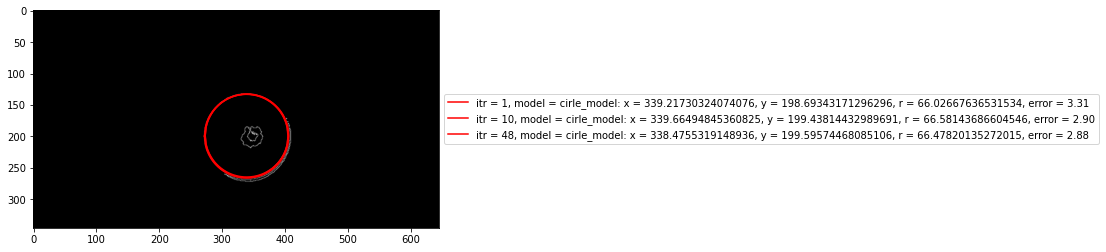

In [ ]:
frames = pupil(videodata[:, :, :, :])

In [ ]:
def moving_average(x, y, window):
  yav = []
  i = 0
  while i < len(x) - window + 1:
    av = y[i:i + window]
    av = sum(av)/window
    yav.append(av)
    i += 1
  return x[:len(x) - (window - 1)] + (window - 1) * (abs(x[0] - x[1])/2), yav
def firstorder(x, y):
  h = x[1] - x[0]
  xfirstorder = x[:-1] + h/2
  yfirstorder = y[1:] - y[:-1]/h
  return xfirstorder, yfirstorder
def blink(framesx, framesy):
  for i in range(len(framesx)):
    if framesy[i] > 10 and framesy[i] < 20:
      start = framesy
      x = framesx
      break
  for i in range(len(framesx[x:])):
    if framesy[i] > 10 and framesy[i] < 20:
      end = framesy
      break
  return start, end, end - start

In [ ]:
results = Parallel(n_jobs=4, verbose=5)(delayed(pupil)(videodata[i:i+1, :, :, :]) for i in range(0, 499))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   44.7s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  7.6min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 13.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 20.8min
[Parallel(n_jobs=4)]: Done 499 out of 499 | elapsed: 23.4min finished


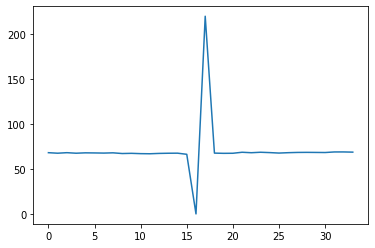

In [ ]:
radx = []
rady = []
for i in range(len(results)):
  radx.append(i)
  rady.append(abs(results[i][0].r))
plt.plot(np.array(radx), np.array(rady))

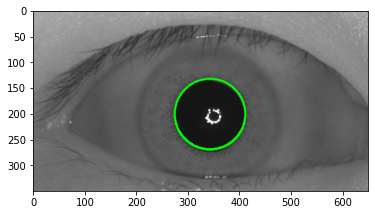

In [ ]:
i = 230
m = results[i - 200][0]
c = cv2.circle(videodata[i, :, :, :],(int(m.x),int(m.y)), int(m.r), (0,255,0), 2)
plt.imshow(c)

In [ ]:
frameSize = (650, 350)
num_frames = 499
out = cv2.VideoWriter("/content/drive/MyDrive/coding/Curve Fitting/"+'output_video.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 30, frameSize)
for i in range(0,num_frames):
  m = results[i][0]
  c = cv2.circle(videodata[i, :, :, :],(int(m.x),int(m.y)), int(m.r), (0,255,0), 2)
  out.write(c)

out.release()